In [1]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, RandomFlip, RandomRotation, RandomContrast, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal 
import keras_tuner as kt
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from scipy.signal import stft
from sklearn.metrics import accuracy_score
import librosa
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback



c:\Users\Luiz\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
# Verificar se a GPU está disponível
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow está usando a GPU.")
else:
    print("TensorFlow está usando a CPU.")

TensorFlow está usando a GPU.


# Import

In [2]:
data = pd.read_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\cwru.pkl")
print(data.shape)
data.head()

(161, 9)


,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...","[-0.24716181818181818, 0.14279090909090908, 0....","[0.015531632047477748, 0.016939940652818994, -..."
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....","[0.07745636363636363, 0.045610909090909084, -0...","[0.07327228486646885, 0.06932902077151336, 0.0..."
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...","[0.1479272727272727, -0.044994545454545454, 0....","[-0.01126646884272997, 0.02265364985163205, 0...."
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
4,ball,DE,14,0,0,True,"[-0.46781317365269465, 0.1790035129740519, 0.4...","[0.09697454545454545, 0.27058363636363636, 0.1...","[0.0016497329376854602, 0.08047477744807123, 0..."


In [ ]:
 # Definindo labels
labels = pd.Series([data['fault_type'][i] + '-' + str(data['fault_size'][i])
                    for i in range(len(data))])
classes = sorted(labels.unique())
classes

['ball-14',
 'ball-21',
 'ball-28',
 'ball-7',
 'inner-14',
 'inner-21',
 'inner-28',
 'inner-7',
 'normal-0',
 'outer-14',
 'outer-21',
 'outer-7']

# Analise exploratoria

## Separando uma amostra de cada classe para os plots

In [14]:
to_plot = data[(data['fault_location'] == 'DE') &
          (data['load'] == '3')
          | (data['fault_location'] == 'normal') &
          (data['load'] == '3')]

# to_plot = to_plot[to_plot['12K'] == True]

to_plot = to_plot.drop_duplicates(subset=['fault_type', 'fault_size'], keep='first')

to_plot

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
7,ball,DE,14,3,0,True,"[0.1054203992015968, -0.10736962075848304, -0....","[0.20463272727272727, 0.24839454545454545, 0.0...","[0.0493712759643917, 0.06248866468842731, 0.04..."
11,ball,DE,21,3,1,True,"[0.07244606786427145, 0.04791836327345309, -0....","[0.11977999999999998, 0.15059818181818183, 0.0...","[-0.07295038575667656, -0.09145958456973295, -..."
15,ball,DE,28,3,2,True,"[-6.5584142, 4.0616758, 7.613099, -2.2330672, ...",None,None
19,inner,DE,7,3,7,True,"[0.2226985628742515, 0.09323776447105789, -0.1...","[-0.09738545454545454, -0.1808, -0.23360181818...","[0.07741673590504453, -0.0024142433234421367, ..."
23,inner,DE,14,3,4,True,"[-0.009908542914171658, 0.06919736526946108, -...","[-0.028558181818181816, -0.11895818181818181, ...","[0.055447121661721076, -0.009133887240356084, ..."
27,inner,DE,21,3,5,True,"[-0.2062926147704591, -0.007309580838323354, 0...","[-0.21264545454545453, -0.12265636363636362, 0...","[-0.06502362017804154, -0.04796296735905045, -..."
31,inner,DE,28,3,6,True,"[-0.9338355, -0.5749497, 0.3812653, 1.1918101,...",None,None
35,outer,DE,7,3,11,True,"[0.16438435129740517, 0.2150641117764471, -0.2...","[-0.08752363636363636, 0.40659454545454543, -0...","[0.002092344213649852, 0.0009656973293768547, ..."
47,outer,DE,14,3,9,True,"[-0.15443784431137725, 0.02866275449101796, -0...","[0.03800909090909091, -0.035954545454545454, 0...","[0.005834421364985164, -0.011427418397626114, ..."


## Plots

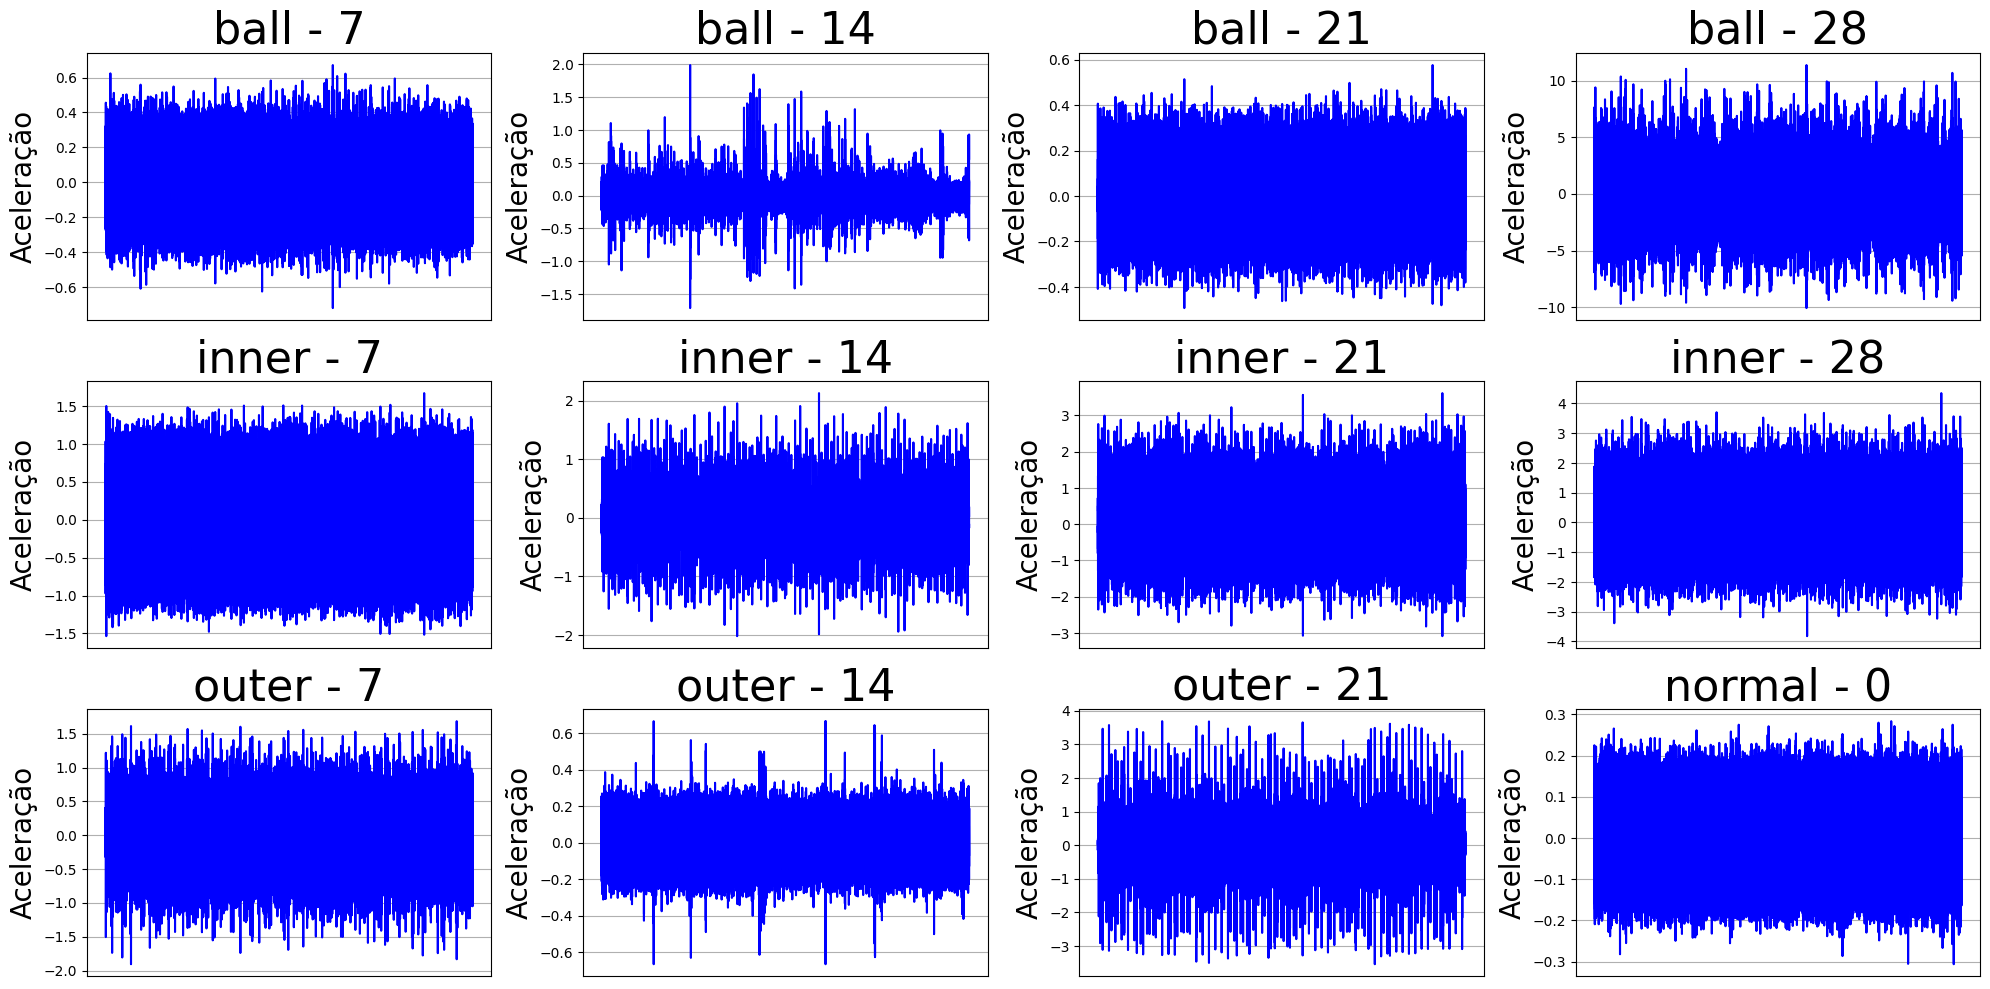

In [16]:
to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    lista = row['DE']
    titulo = f"{row['fault_type']} - {row['fault_size']}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna
    # Plotar a lista no gráfico
    ax.plot(lista, color='b')
    ax.set_title(titulo, fontsize = 32)
    # ax.set_xlabel('Índice')
    ax.set_xticks([])
    ax.set_ylabel('Aceleração',fontsize = 20)
    ax.grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## Função para downsample

Artigo aplica um downsample para uma amostragem de 6kHz

In [6]:
def downsample(df, f_sample = 12e3):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    sr_12k = 12e3  # Taxa de amostragem se 'coluna_boolean' for True
    sr_48k = 48e3  # Taxa de amostragem se 'coluna_boolean' for False

    DE = row['DE'] #Identificar dados DE
    FE = row['FE'] #Identificar dados FE
    BA = row['BA'] #Identificar dados BA

    sr_original = sr_12k if row['12K'] else sr_48k

    data = []

    if DE is not None:
      DE = np.array(row['DE'])
      data.append(DE)

    if FE is not None:
      FE = np.array(row['FE'])
      data.append(FE)

    if BA is not None:
      BA = np.array(row['BA'])
      data.append(BA)

    data_downsampled = []
    for sinal in data:
      # print(sinal)
      sinal = np.array(sinal)
      down_sample = librosa.resample(sinal, orig_sr=sr_original, target_sr=f_sample)

      data_downsampled.append(down_sample)

    df_temp = pd.DataFrame(data_downsampled)

    df_temp = df_temp.apply(lambda row: np.array(row[~np.isnan(row)] ,dtype = float), axis=1)

    df_temp = df_temp.to_frame(name='data')

    df_temp['label'] = row['label']

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)
  return df_final


df_downsampled = downsample(to_plot)
df_downsampled.head()

,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[0.07232, -0.007807272727272727, 0.12327272727...",3
2,"[-0.05460213649851632, -0.05778089020771514, -...",3
3,"[0.1054203992015968, -0.10736962075848304, -0....",0
4,"[0.20463272727272727, 0.24839454545454545, 0.0...",0


## Implementação e teste da Segmentação


Além da mudança na amostragem é feito uma segmentação com tamanho de 1600 pontos

In [7]:
def segment_signal(signal, window_size, overlap=0):
    """
    Segmenta um sinal em janelas de tamanho fixo, com uma sobreposição opcional.

    Parâmetros:
        signal (array-like): O sinal a ser segmentado (lista ou numpy array).
        window_size (int): O tamanho de cada segmento (janela).
        overlap (int, opcional): O número de amostras que devem sobrepor entre janelas.
                                 Por padrão é 0 (sem sobreposição).

    Retorno:
        list: Uma lista contendo as janelas segmentadas do sinal.
    """
    if window_size <= 0:
        raise ValueError("O tamanho da janela deve ser maior que zero.")
    if overlap >= window_size:
        raise ValueError("A sobreposição deve ser menor que o tamanho da janela.")

    step = window_size - overlap
    segments = [signal[i:i + window_size] for i in range(0, len(signal) - window_size + 1, step)]

    return segments

In [8]:
def segmentação(df, tamanho_segmento = 1600):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']



    segmentos = segment_signal(data,tamanho_segmento,tamanho_segmento//2)

    for segmento in segmentos:

      df_temp = pd.DataFrame({'data': [segmento], 'label': [label]})
      df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_segmentado = segmentação(df_downsampled)
df_segmentado.head()


,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[-0.007959321357285429, -0.17429289421157684, ...",3
2,"[-0.1780289021956088, -0.1954094610778443, 0.1...",3
3,"[-0.043045309381237525, 0.28036303393213574, 0...",3
4,"[0.21993716566866267, -0.049380279441117766, -...",3


## Implementação e teste da STFT

In [9]:
def get_stft(df, janela = 128, passo = 32):
  df_final = pd.DataFrame(columns = ['stft', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']
    noverlap = janela - passo

    # Aplicar a transformada STFT
    f, t, stft_result = stft(np.array(data),fs = 12000 ,nperseg = janela, noverlap = noverlap)

    df_temp = pd.DataFrame({'stft': [np.delete(np.abs(stft_result),-1,1)], 'label': [label]})

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_stft = get_stft(df_segmentado)
df_stft.head()


,stft,label
0,"[[0.0046627964379330165, 0.004969686013366023,...",3
1,"[[0.0036535953150725136, 0.00220930525729235, ...",3
2,"[[0.003896214181431377, 0.002196604235786035, ...",3
3,"[[0.0027944988184996147, 0.005684842785698682,...",3
4,"[[0.009487218032625885, 0.004989715404617692, ...",3


In [10]:
df_stft["label"].value_counts()

label
7     456
0     453
1     453
4     453
5     453
11    453
9     453
10    453
3     450
8     300
2     150
6     150
Name: count, dtype: int64

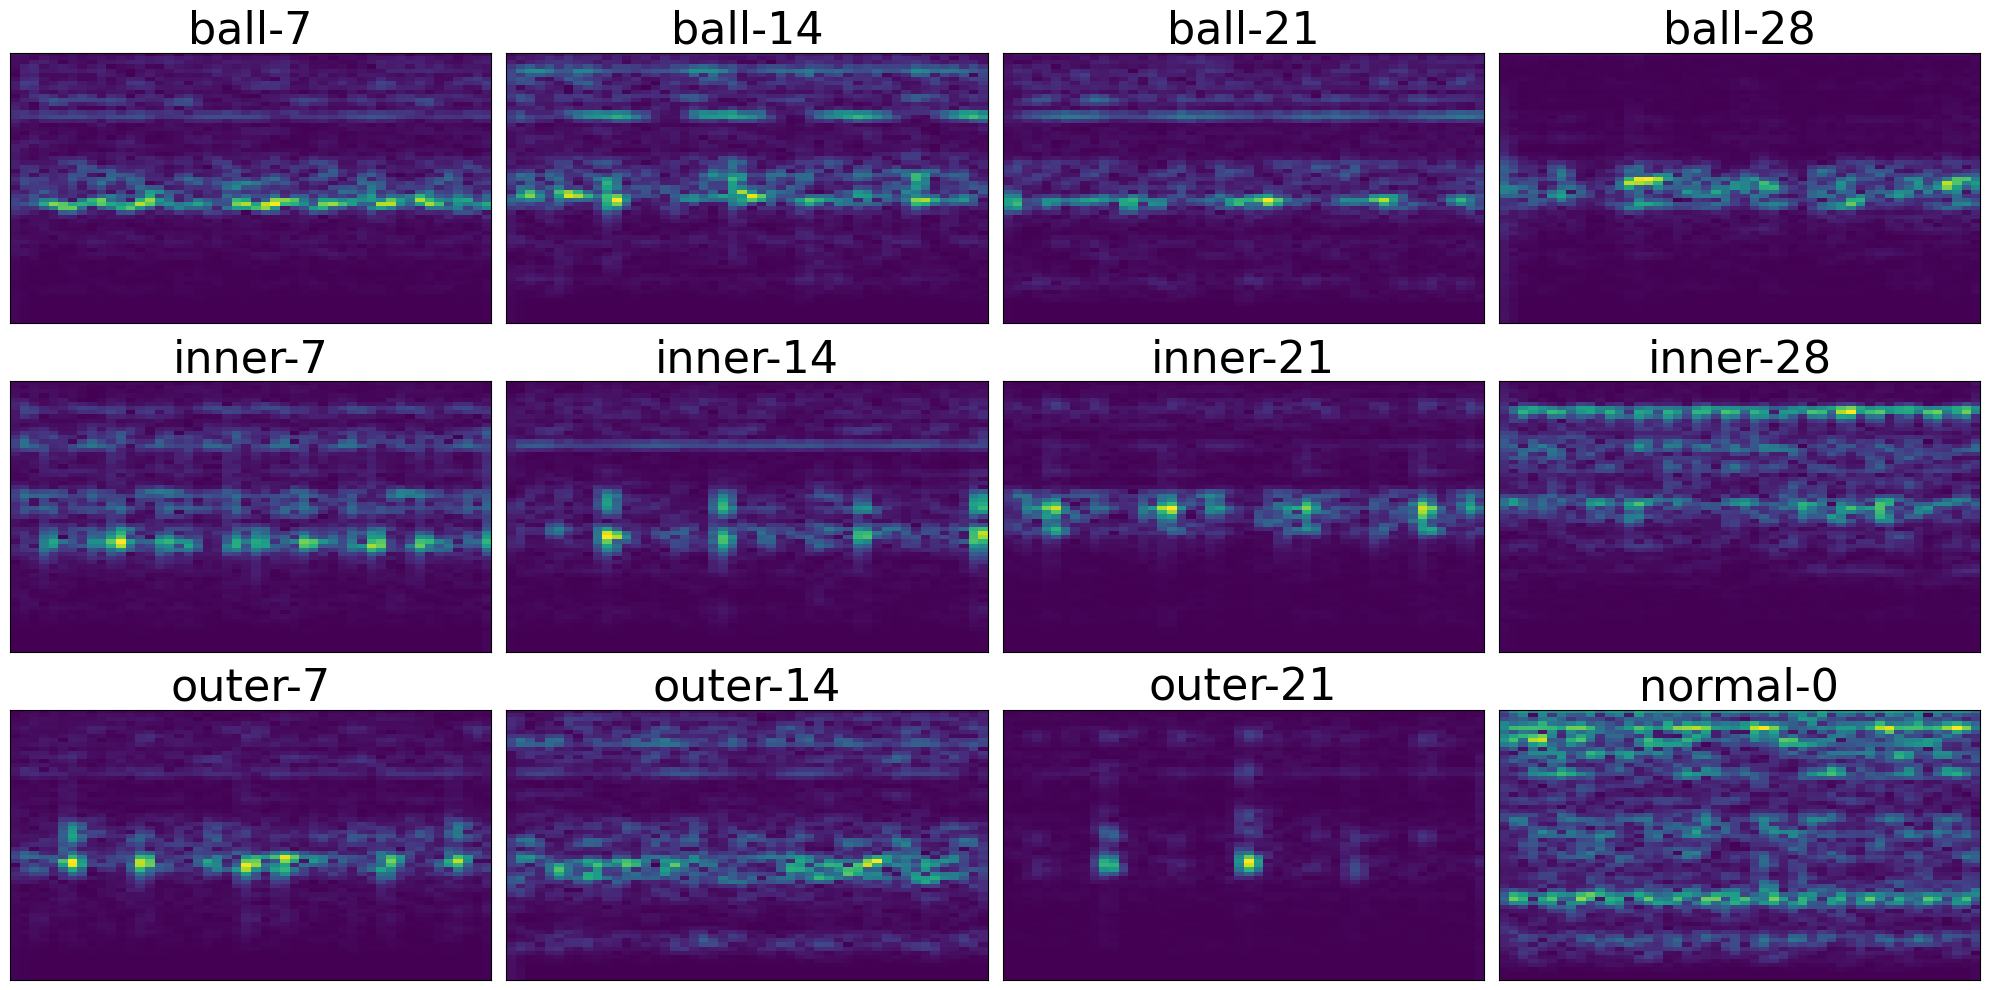

In [13]:
to_plot = df_stft.drop_duplicates(subset=['label'], keep='first')

to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    matriz = row['stft']
    titulo = f"{classes[int(row['label'])]}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna

    # Plotar a matriz 2D usando imshow
    cax = ax.imshow(np.abs(matriz), cmap='viridis', aspect='auto')
    ax.set_title(titulo, fontsize = 32)
    ax.set_xticks([])
    ax.set_yticks([])

    # Adicionar uma barra de cor para cada subplot
    # fig.colorbar(cax, ax=ax)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Preparação dos dados

In [115]:
def process_de_fault(df):
  """
  Extrai as medições da coluna FE para linhas com 'fault_location' == DE e as considera saudavel.
  """
  new_rows = []
  for index, row in df.iterrows():
    if row['fault_location'] == 'DE':
      if row['FE'] is not None:  
        new_row = row.copy()
        new_row['DE'] = None 
        row['FE'] = None
        new_row['fault_type'] = 'normal'
        new_row['fault_location'] = 'normal'
        new_row['label'] = 8
        new_rows.append(row)
        new_rows.append(new_row)
      else:
        new_rows.append(row)
    else:
      new_rows.append(row)
  return pd.DataFrame(new_rows)

In [116]:
#Filtragem
dados = data[(data['fault_location'] == 'DE') | (data['fault_location'] == 'normal') ]
dados = df_processed = process_de_fault(dados)
dados.loc[(data['fault_location'] == 'DE'), 'BA'] = None
dados

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...",None,None
0,normal,normal,7,0,8,True,None,"[-0.24716181818181818, 0.14279090909090908, 0....",None
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....",None,None
1,normal,normal,7,1,8,True,None,"[0.07745636363636363, 0.045610909090909084, -0...",None
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...",None,None
...,...,...,...,...,...,...,...,...,...
156,normal,normal,21,3,8,False,None,"[0.10028646464646465, 0.04356707070707071, -0....",None
157,normal,normal,0,3,8,False,"[0.014603076923076923, 0.05444861538461539, 0....","[0.19292181818181817, 0.16436363636363635, 0.0...",None
158,normal,normal,0,0,8,False,"[0.05319692307692307, 0.08866153846153846, 0.0...","[0.14566727272727273, 0.09779636363636364, 0.0...",None
159,normal,normal,0,1,8,False,"[0.046104, -0.03713353846153846, -0.0894959999...","[0.023216363636363632, 0.08115454545454545, 0....",None


In [ ]:
#Contagem antes de segmentar
dados['label'].value_counts()

label
8     108
11     24
10     24
3       8
0       8
1       8
7       8
4       8
5       8
9       8
2       4
6       4
Name: count, dtype: int64

In [118]:
dados['fault_location'].value_counts()

fault_location
DE        112
normal    108
Name: count, dtype: int64

In [119]:
df_downsampled = downsample(dados)
df_segmentacao = segmentação(df_downsampled)
df = get_stft(df_segmentacao)
df.head()

,stft,label
0,"[[0.01157540145002548, 0.01762599445935281, 0....",3
1,"[[0.004265486339463177, 0.015360822443847151, ...",3
2,"[[0.0010559130214167268, 0.011062785048560776,...",3
3,"[[0.009037516468552796, 0.013847087892614705, ...",3
4,"[[0.006196306520358481, 0.01356841395415791, 0...",3


In [120]:
df.iloc[0]['stft'].shape

(65, 50)

In [121]:
df.shape

(31182, 2)

In [122]:
df['label'].value_counts()

label
8     15516
10     3325
11     3315
0      1132
1      1132
5      1131
9      1131
3      1130
7      1129
4      1041
2       600
6       600
Name: count, dtype: int64

In [ ]:
df.to_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\stft.pkl")

In [17]:
df = pd.read_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\stft.pkl")

# Separação dos dados

In [18]:
def sample_labels_exact(df, label_col, n_samples):
    """
    Mantém exatamente `n_samples` amostras para cada valor na coluna `label_col`.

    Parâmetros:
        df (pd.DataFrame): O DataFrame original.
        label_col (str): O nome da coluna de rótulos (labels).
        n_samples (int): O número de amostras a manter para cada label.

    Retorno:
        pd.DataFrame: Um novo DataFrame com as amostras selecionadas.
    """
    sampled_df = (
        df.groupby(label_col, group_keys=False)
          .apply(lambda x: x.sample(n=n_samples, random_state=42))
    )
    return sampled_df.reset_index(drop=True)


In [19]:
def prepare_data(series):
    """
    Prepara uma série contendo arrays 2D para entrada em um modelo.

    Args:
        series (pd.Series): Série com arrays 2D do NumPy.

    Returns:
        np.ndarray: Array 4D pronto para ser usado como entrada do modelo.
    """
    # Verificar a consistência das dimensões
    shapes = series.apply(lambda x: x.shape)
    if not all(shape == shapes.iloc[0] for shape in shapes):
        raise ValueError("Todos os arrays devem ter dimensões consistentes.")

    # Expandir a dimensão para incluir o canal (1 para escala de cinza)
    arrays = series.apply(lambda x: np.expand_dims(x, axis=-1)).values

    # Consolidar em um único array 4D
    data = np.stack(arrays, axis=0)

    # Normalizar os valores (ajuste conforme necessário para seu modelo)
    # data = data / 255.0  # Normalizando para [0, 1]

    return data

In [ ]:
#Escolhe 600 amostras de cada classe aleatóriamente
df_sampled = sample_labels_exact(df, 'label', 600)
df_sampled['label'].value_counts()

C:\Users\Luiz\AppData\Local\Temp\ipykernel_16980\3058520353.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(label_col, group_keys=False)


label
0     600
1     600
2     600
3     600
4     600
5     600
6     600
7     600
8     600
9     600
10    600
11    600
Name: count, dtype: int64

In [ ]:
#Split treino e teste+validação
df_train, df_test = train_test_split(df_sampled,train_size=0.5,stratify=df_sampled['label'], random_state= 42)
df_val, df_test = train_test_split(df_test, train_size = 1/3, stratify=df_test['label'], random_state= 42)


#Aplicar prepare_data para transformar em array 4D
X_train = prepare_data(df_train['stft'])
#Aplicar to_categorical para ser compativel com categorical_crossentropy
y_train = to_categorical(df_train['label'], num_classes=12)
df_train['label'].value_counts()

label
4     300
3     300
9     300
1     300
8     300
2     300
5     300
7     300
11    300
10    300
0     300
6     300
Name: count, dtype: int64

In [ ]:
#Aplicar prepare_data para transformar em array 4D
X_val = prepare_data(df_val['stft'])
#Aplicar to_categorical para ser compativel com categorical_crossentropy
y_val = to_categorical(df_val['label'], num_classes=12)
df_val['label'].value_counts()

label
6     100
11    100
2     100
3     100
7     100
10    100
0     100
9     100
4     100
8     100
5     100
1     100
Name: count, dtype: int64

In [ ]:
#Aplicar prepare_data para transformar em array 4D
X_test = prepare_data(df_test['stft'])
#Aplicar to_categorical para ser compativel com categorical_crossentropy
y_test = to_categorical(df_test['label'], num_classes=12)
df_test['label'].value_counts()

label
11    200
9     200
6     200
4     200
5     200
3     200
2     200
7     200
10    200
1     200
0     200
8     200
Name: count, dtype: int64

In [ ]:
#Verificar shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3600, 65, 50, 1)
(1200, 65, 50, 1)
(2400, 65, 50, 1)
(3600, 12)
(1200, 12)
(2400, 12)


In [ ]:
#Normalizazr
X_train = X_train/np.max(X_train)
X_val = X_val/np.max(X_train)
X_test = X_test/np.max(X_train)

# Montar modelos

In [ ]:
#Função para montar o modelo
def get_CNN3():
    CNN3 = Sequential([
        Input((65,50,1)),
        Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Flatten(),

        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.5),
        Dense(12, activation='softmax')

    ])
    return CNN3

CNN3 = get_CNN3()

#Calculo dos FLOPS para comparar com o artigo
@tf.function
def model_fn(input_tensor):
    return CNN3(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN3.summary()

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS totais: 0.2846 (G)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 50, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 50, 64)        2112      
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 50, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 65, 50, 64)        2112      
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 50, 32)        18464     
                                                                 
 conv2d_5 (Conv2D)           (None, 65, 50, 64)        2112      
        

In [ ]:
#Função para montar o modelo
def get_CNN2():
    CNN2 = Sequential([
        Input((65,50,1)),
        Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same', kernel_initializer=HeNormal()),
        Flatten(),

        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_initializer=HeNormal()),
        Dropout(0.5),
        Dense(12, activation='softmax')

    ])
    return CNN2

CNN2 = get_CNN2()

#Calculo dos FLOPS para comparar com o artigo
@tf.function
def model_fn(input_tensor):
    return CNN2(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN2.summary()

FLOPS totais: 0.1511 (G)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 65, 50, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 65, 50, 64)        2112      
                                                                 
 conv2d_9 (Conv2D)           (None, 65, 50, 32)        18464     
                                                                 
 conv2d_10 (Conv2D)          (None, 65, 50, 64)        2112      
                                                                 
 conv2d_11 (Conv2D)          (None, 65, 50, 1)         65        
                                                                 
 flatten_1 (Flatten)         (None, 3250)              0         
                                                                 
 dense_3 (Dense)             

In [ ]:
#Função para montar o modelo
def get_liteCNN():
    liteCNN = Sequential([
    Input((65,50, 1)),
    Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
    Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal()),
    Conv2D(1, (1, 1), activation='relu', strides= 1, padding = 'same', kernel_initializer=HeNormal() ),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(12, activation='softmax')
    ])
    
    return liteCNN

liteCNN = get_liteCNN()

#Calculo dos FLOPS para comparar com o artigo
@tf.function
def model_fn(input_tensor):
    return liteCNN(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

liteCNN.summary()

FLOPS totais: 0.0177 (G)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 65, 50, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 65, 50, 64)        2112      
                                                                 
 conv2d_14 (Conv2D)          (None, 65, 50, 1)         65        
                                                                 
 flatten_2 (Flatten)         (None, 3250)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               832256    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             

In [ ]:
#Função para montar o modelo
def get_CNN0():
    CNN0 = Sequential([
    Input((65,50,1)),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(12, activation='softmax')
])
    
    return CNN0

CNN0 = get_CNN0()

#Calculo dos FLOPS para comparar com o artigo
@tf.function
def model_fn(input_tensor):
    return CNN0(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN0.summary()

FLOPS totais: 0.0018 (G)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3250)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               832256    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 12)                3084      
                                                                 
Total params: 901,132
Trainab

# Otimização de Hiperparametros

In [ ]:
def compile_model(model_idx, lr):

    models = [
        get_CNN3(),
        get_CNN2(),
        get_liteCNN(),
        get_CNN0(),
        ]
    
    model = models[model_idx]
    
        
    # Otimizar learning_rate
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [40]:
def hp_opt(model_raw, name, patience = 10):

    # Espaço de busca para os hiperparâmetros
    batch_sizes = [16, 32, 64, 128]
    learning_rates = [1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1]

    # Variáveis para armazenar os melhores resultados
    best_accuracy = 0
    best_params = {}

    # Loop sobre os hiperparâmetros
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            print(f"Treinando com batch_size={batch_size} e learning_rate={learning_rate}")
            
            # Criar o modelo
            model = compile_model(model_raw, learning_rate)
            callbacks = [EarlyStopping(patience=patience)] + [TqdmCallback(verbose=1)]
            # Treinar o modelo
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=50,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks
            )
            
            # Avaliar o modelo
            val_accuracy = history.history['val_accuracy'][-1]
            print(f"Val accuracy: {val_accuracy:.4f}")
            
            # Atualizar os melhores parâmetros
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

    # Exibir os melhores parâmetros
    print(f"\nMelhores Hiperparâmetros do {name}:")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Melhor Acurácia: {best_accuracy:.4f}")

    return best_params['learning_rate'], best_params['batch_size']

In [ ]:
names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    ]

best_hp = {f'{name}':{'lr':0, 'batch':0} for name in names}
best_hp

{'CNN3': {'lr': 0, 'batch': 0},
 'CNN2': {'lr': 0, 'batch': 0},
 'liteCNN': {'lr': 0, 'batch': 0},
 'CNN0': {'lr': 0, 'batch': 0}}

In [ ]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    ]


for i, model in enumerate(models):
    best_hp[names[i]]['lr'], best_hp[names[i]]['batch'] = hp_opt(i, names[i])

Treinando com batch_size=16 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [01:48<00:00,  2.17s/epoch, loss=1.63, accuracy=0.463, val_loss=1.28, val_accuracy=0.538]


Val accuracy: 0.5375
Treinando com batch_size=16 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

 62%|██████▏   | 31/50 [01:08<00:42,  2.22s/epoch, loss=0.209, accuracy=0.938, val_loss=0.289, val_accuracy=0.897]


Val accuracy: 0.8975
Treinando com batch_size=16 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 56%|█████▌    | 28/50 [01:01<00:48,  2.20s/epoch, loss=0.0278, accuracy=0.993, val_loss=0.024, val_accuracy=0.997] 


Val accuracy: 0.9967
Treinando com batch_size=16 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 36%|███▌      | 18/50 [00:39<01:10,  2.20s/epoch, loss=0.0209, accuracy=0.991, val_loss=0.0502, val_accuracy=0.996]


Val accuracy: 0.9958
Treinando com batch_size=16 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 32%|███▏      | 16/50 [00:34<01:13,  2.16s/epoch, loss=2.49, accuracy=0.0753, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=16 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 42%|████▏     | 21/50 [00:44<01:02,  2.14s/epoch, loss=2.5, accuracy=0.085, val_loss=2.5, val_accuracy=0.0833]   


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=1e-06


100%|██████████| 50/50 [01:18<00:00,  1.57s/epoch, loss=1.84, accuracy=0.377, val_loss=1.53, val_accuracy=0.458] 


Val accuracy: 0.4575
Treinando com batch_size=32 e learning_rate=1e-05


100%|██████████| 50/50 [01:17<00:00,  1.56s/epoch, loss=0.149, accuracy=0.956, val_loss=0.278, val_accuracy=0.918]


Val accuracy: 0.9175
Treinando com batch_size=32 e learning_rate=0.0001


 62%|██████▏   | 31/50 [00:48<00:29,  1.57s/epoch, loss=0.0295, accuracy=0.991, val_loss=0.0199, val_accuracy=0.998]


Val accuracy: 0.9983
Treinando com batch_size=32 e learning_rate=0.001


 40%|████      | 20/50 [00:31<00:47,  1.59s/epoch, loss=0.0134, accuracy=0.995, val_loss=0.079, val_accuracy=0.994] 


Val accuracy: 0.9942
Treinando com batch_size=32 e learning_rate=0.01


 36%|███▌      | 18/50 [00:28<00:51,  1.59s/epoch, loss=2.49, accuracy=0.0692, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=0.1


 46%|████▌     | 23/50 [00:34<00:39,  1.48s/epoch, loss=2.5, accuracy=0.0836, val_loss=2.5, val_accuracy=0.0833]   


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

 68%|██████▊   | 34/50 [00:40<00:19,  1.20s/epoch, loss=2.25, accuracy=0.171, val_loss=2.28, val_accuracy=0.169] 


Val accuracy: 0.1692
Treinando com batch_size=64 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

 44%|████▍     | 22/50 [00:26<00:33,  1.20s/epoch, loss=0.734, accuracy=0.752, val_loss=2.69, val_accuracy=0.286]


Val accuracy: 0.2858
Treinando com batch_size=64 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 82%|████████▏ | 41/50 [00:48<00:10,  1.19s/epoch, loss=0.0284, accuracy=0.992, val_loss=0.0279, val_accuracy=0.993]


Val accuracy: 0.9925
Treinando com batch_size=64 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 36%|███▌      | 18/50 [00:21<00:38,  1.22s/epoch, loss=0.0211, accuracy=0.995, val_loss=0.0507, val_accuracy=0.989]


Val accuracy: 0.9892
Treinando com batch_size=64 e learning_rate=0.01


 56%|█████▌    | 28/50 [00:34<00:26,  1.21s/epoch, loss=2.49, accuracy=0.0719, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 22%|██▏       | 11/50 [00:14<00:50,  1.28s/epoch, loss=2.5, accuracy=0.0858, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:54<00:00,  1.09s/epoch, loss=2.21, accuracy=0.179, val_loss=2.19, val_accuracy=0.174] 


Val accuracy: 0.1742
Treinando com batch_size=128 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:54<00:00,  1.09s/epoch, loss=0.573, accuracy=0.818, val_loss=0.49, val_accuracy=0.814] 


Val accuracy: 0.8142
Treinando com batch_size=128 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:54<00:00,  1.10s/epoch, loss=0.0254, accuracy=0.993, val_loss=0.0653, val_accuracy=0.979]


Val accuracy: 0.9792
Treinando com batch_size=128 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 46%|████▌     | 23/50 [00:25<00:29,  1.10s/epoch, loss=0.0163, accuracy=0.995, val_loss=0.0424, val_accuracy=0.998]


Val accuracy: 0.9983
Treinando com batch_size=128 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 44%|████▍     | 22/50 [00:24<00:30,  1.10s/epoch, loss=2.49, accuracy=0.0803, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 80%|████████  | 40/50 [00:43<00:10,  1.08s/epoch, loss=2.49, accuracy=0.0783, val_loss=2.49, val_accuracy=0.0833] 


Val accuracy: 0.0833

Melhores Hiperparâmetros do CNN3:
Batch Size: 32
Learning Rate: 0.0001
Melhor Acurácia: 0.9983
Treinando com batch_size=16 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [01:20<00:00,  1.60s/epoch, loss=1.93, accuracy=0.312, val_loss=2.06, val_accuracy=0.302] 


Val accuracy: 0.3017
Treinando com batch_size=16 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

 28%|██▊       | 14/50 [00:22<00:58,  1.62s/epoch, loss=2.48, accuracy=0.0808, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=16 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 50%|█████     | 25/50 [00:40<00:40,  1.61s/epoch, loss=0.0254, accuracy=0.993, val_loss=0.0231, val_accuracy=0.998]


Val accuracy: 0.9975
Treinando com batch_size=16 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [01:20<00:00,  1.61s/epoch, loss=2.49, accuracy=0.0761, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=16 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 32%|███▏      | 16/50 [00:26<00:55,  1.63s/epoch, loss=2.49, accuracy=0.0767, val_loss=2.48, val_accuracy=0.0908]


Val accuracy: 0.0908
Treinando com batch_size=16 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 28%|██▊       | 14/50 [00:22<00:58,  1.62s/epoch, loss=2.51, accuracy=0.0817, val_loss=2.51, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=1e-06


100%|██████████| 50/50 [00:55<00:00,  1.11s/epoch, loss=2.15, accuracy=0.289, val_loss=2.28, val_accuracy=0.339] 


Val accuracy: 0.3392
Treinando com batch_size=32 e learning_rate=1e-05


100%|██████████| 50/50 [00:55<00:00,  1.11s/epoch, loss=0.217, accuracy=0.936, val_loss=0.222, val_accuracy=0.915]


Val accuracy: 0.9150
Treinando com batch_size=32 e learning_rate=0.0001


 22%|██▏       | 11/50 [00:12<00:44,  1.14s/epoch, loss=0.252, accuracy=0.917, val_loss=4.69, val_accuracy=0.347]


Val accuracy: 0.3467
Treinando com batch_size=32 e learning_rate=0.001


 38%|███▊      | 19/50 [00:21<00:34,  1.13s/epoch, loss=0.0379, accuracy=0.99, val_loss=0.103, val_accuracy=0.984]  


Val accuracy: 0.9842
Treinando com batch_size=32 e learning_rate=0.01


 26%|██▌       | 13/50 [00:15<00:42,  1.16s/epoch, loss=2.49, accuracy=0.0781, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=0.1


 22%|██▏       | 11/50 [00:12<00:45,  1.16s/epoch, loss=2.5, accuracy=0.0758, val_loss=2.5, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=1e-06


100%|██████████| 50/50 [00:43<00:00,  1.16epoch/s, loss=2.11, accuracy=0.193, val_loss=2.12, val_accuracy=0.174]


Val accuracy: 0.1742
Treinando com batch_size=64 e learning_rate=1e-05


100%|██████████| 50/50 [00:44<00:00,  1.13epoch/s, loss=0.386, accuracy=0.89, val_loss=0.184, val_accuracy=0.933] 


Val accuracy: 0.9333
Treinando com batch_size=64 e learning_rate=0.0001


 86%|████████▌ | 43/50 [00:37<00:06,  1.13epoch/s, loss=0.036, accuracy=0.99, val_loss=0.0202, val_accuracy=0.997]  


Val accuracy: 0.9967
Treinando com batch_size=64 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 40%|████      | 20/50 [00:17<00:26,  1.11epoch/s, loss=0.0148, accuracy=0.996, val_loss=0.0252, val_accuracy=0.998]


Val accuracy: 0.9975
Treinando com batch_size=64 e learning_rate=0.01


 50%|█████     | 25/50 [00:21<00:21,  1.14epoch/s, loss=2.49, accuracy=0.0722, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=0.1


 28%|██▊       | 14/50 [00:12<00:31,  1.13epoch/s, loss=2.5, accuracy=0.0775, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:37<00:00,  1.33epoch/s, loss=2.47, accuracy=0.129, val_loss=2.45, val_accuracy=0.129]  


Val accuracy: 0.1292
Treinando com batch_size=128 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

 72%|███████▏  | 36/50 [00:27<00:10,  1.30epoch/s, loss=1.13, accuracy=0.628, val_loss=2.17, val_accuracy=0.26] 


Val accuracy: 0.2600
Treinando com batch_size=128 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 60%|██████    | 30/50 [00:22<00:15,  1.33epoch/s, loss=0.07, accuracy=0.983, val_loss=0.152, val_accuracy=0.947]  


Val accuracy: 0.9475
Treinando com batch_size=128 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 30%|███       | 15/50 [00:11<00:26,  1.30epoch/s, loss=2.49, accuracy=0.0808, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 44%|████▍     | 22/50 [00:16<00:21,  1.31epoch/s, loss=2.49, accuracy=0.0833, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 36%|███▌      | 18/50 [00:13<00:24,  1.29epoch/s, loss=2.49, accuracy=0.0761, val_loss=2.5, val_accuracy=0.0833] 


Val accuracy: 0.0833

Melhores Hiperparâmetros do CNN2:
Batch Size: 16
Learning Rate: 0.0001
Melhor Acurácia: 0.9975
Treinando com batch_size=16 e learning_rate=1e-06


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:57<00:00,  1.15s/epoch, loss=2.11, accuracy=0.233, val_loss=2.03, val_accuracy=0.222] 


Val accuracy: 0.2217
Treinando com batch_size=16 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

 50%|█████     | 25/50 [00:29<00:29,  1.17s/epoch, loss=0.918, accuracy=0.692, val_loss=1.98, val_accuracy=0.367]


Val accuracy: 0.3667
Treinando com batch_size=16 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:58<00:00,  1.17s/epoch, loss=0.0287, accuracy=0.994, val_loss=0.0375, val_accuracy=0.994]


Val accuracy: 0.9942
Treinando com batch_size=16 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 22%|██▏       | 11/50 [00:13<00:46,  1.20s/epoch, loss=0.293, accuracy=0.9, val_loss=3.72, val_accuracy=0.393]  


Val accuracy: 0.3933
Treinando com batch_size=16 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 60%|██████    | 30/50 [00:36<00:24,  1.20s/epoch, loss=1.11, accuracy=0.6, val_loss=7.12, val_accuracy=0.633]    


Val accuracy: 0.6333
Treinando com batch_size=16 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 70%|███████   | 35/50 [00:41<00:17,  1.18s/epoch, loss=2.5, accuracy=0.0808, val_loss=2.51, val_accuracy=0.0833] 


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=1e-06


100%|██████████| 50/50 [00:33<00:00,  1.48epoch/s, loss=2.24, accuracy=0.271, val_loss=2.02, val_accuracy=0.252]


Val accuracy: 0.2517
Treinando com batch_size=32 e learning_rate=1e-05


100%|██████████| 50/50 [00:32<00:00,  1.53epoch/s, loss=0.594, accuracy=0.829, val_loss=0.219, val_accuracy=0.935]


Val accuracy: 0.9350
Treinando com batch_size=32 e learning_rate=0.0001


 98%|█████████▊| 49/50 [00:32<00:00,  1.53epoch/s, loss=0.0147, accuracy=0.997, val_loss=0.0232, val_accuracy=0.998]


Val accuracy: 0.9983
Treinando com batch_size=32 e learning_rate=0.001


 38%|███▊      | 19/50 [00:13<00:21,  1.46epoch/s, loss=2.49, accuracy=0.0711, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=0.01


 58%|█████▊    | 29/50 [00:19<00:13,  1.51epoch/s, loss=2.49, accuracy=0.0797, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=0.1


 52%|█████▏    | 26/50 [00:17<00:15,  1.50epoch/s, loss=2.5, accuracy=0.0794, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=1e-06


100%|██████████| 50/50 [00:22<00:00,  2.24epoch/s, loss=2.22, accuracy=0.185, val_loss=2.15, val_accuracy=0.182]


Val accuracy: 0.1817
Treinando com batch_size=64 e learning_rate=1e-05


100%|██████████| 50/50 [00:22<00:00,  2.27epoch/s, loss=1.01, accuracy=0.716, val_loss=0.523, val_accuracy=0.836]


Val accuracy: 0.8358
Treinando com batch_size=64 e learning_rate=0.0001


 28%|██▊       | 14/50 [00:06<00:16,  2.14epoch/s, loss=0.378, accuracy=0.874, val_loss=2.54, val_accuracy=0.396]


Val accuracy: 0.3958
Treinando com batch_size=64 e learning_rate=0.001


 62%|██████▏   | 31/50 [00:14<00:08,  2.19epoch/s, loss=0.0357, accuracy=0.99, val_loss=0.0699, val_accuracy=0.983] 


Val accuracy: 0.9825
Treinando com batch_size=64 e learning_rate=0.01


 56%|█████▌    | 28/50 [00:13<00:10,  2.05epoch/s, loss=2.49, accuracy=0.0758, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=64 e learning_rate=0.1


 28%|██▊       | 14/50 [00:06<00:16,  2.14epoch/s, loss=2.5, accuracy=0.0753, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=1e-06


 32%|███▏      | 16/50 [00:06<00:12,  2.64epoch/s, loss=2.48, accuracy=0.0817, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=1e-05


100%|██████████| 50/50 [00:17<00:00,  2.78epoch/s, loss=1.4, accuracy=0.581, val_loss=1.13, val_accuracy=0.562] 


Val accuracy: 0.5617
Treinando com batch_size=128 e learning_rate=0.0001


 22%|██▏       | 11/50 [00:04<00:15,  2.54epoch/s, loss=2.48, accuracy=0.0833, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=0.001


 24%|██▍       | 12/50 [00:04<00:14,  2.60epoch/s, loss=2.48, accuracy=0.0808, val_loss=2.48, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=128 e learning_rate=0.01


 64%|██████▍   | 32/50 [00:11<00:06,  2.78epoch/s, loss=1.1, accuracy=0.577, val_loss=1.57, val_accuracy=0.696]    


Val accuracy: 0.6958
Treinando com batch_size=128 e learning_rate=0.1


 48%|████▊     | 24/50 [00:08<00:09,  2.80epoch/s, loss=2.49, accuracy=0.0769, val_loss=2.49, val_accuracy=0.0833]


Val accuracy: 0.0833

Melhores Hiperparâmetros do liteCNN:
Batch Size: 32
Learning Rate: 0.0001
Melhor Acurácia: 0.9983
Treinando com batch_size=16 e learning_rate=1e-06


100%|██████████| 50/50 [00:42<00:00,  1.17epoch/s, loss=2.2, accuracy=0.183, val_loss=2.11, val_accuracy=0.187]  


Val accuracy: 0.1867
Treinando com batch_size=16 e learning_rate=1e-05


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:43<00:00,  1.16epoch/s, loss=1.1, accuracy=0.711, val_loss=0.884, val_accuracy=0.66]  


Val accuracy: 0.6600
Treinando com batch_size=16 e learning_rate=0.0001


  0%|          | 0/50 [00:00<?, ?epoch/s]

100%|██████████| 50/50 [00:44<00:00,  1.13epoch/s, loss=0.0439, accuracy=0.994, val_loss=0.307, val_accuracy=0.906]


Val accuracy: 0.9058
Treinando com batch_size=16 e learning_rate=0.001


  0%|          | 0/50 [00:00<?, ?epoch/s]

 44%|████▍     | 22/50 [00:19<00:25,  1.11epoch/s, loss=0.0236, accuracy=0.993, val_loss=0.386, val_accuracy=0.908]


Val accuracy: 0.9083
Treinando com batch_size=16 e learning_rate=0.01


  0%|          | 0/50 [00:00<?, ?epoch/s]

 34%|███▍      | 17/50 [00:15<00:29,  1.12epoch/s, loss=0.573, accuracy=0.818, val_loss=0.396, val_accuracy=0.873]


Val accuracy: 0.8725
Treinando com batch_size=16 e learning_rate=0.1


  0%|          | 0/50 [00:00<?, ?epoch/s]

 24%|██▍       | 12/50 [00:10<00:32,  1.15epoch/s, loss=2.51, accuracy=0.0819, val_loss=2.51, val_accuracy=0.0833]


Val accuracy: 0.0833
Treinando com batch_size=32 e learning_rate=1e-06


100%|██████████| 50/50 [00:24<00:00,  2.07epoch/s, loss=2.32, accuracy=0.2, val_loss=2.14, val_accuracy=0.193]   


Val accuracy: 0.1933
Treinando com batch_size=32 e learning_rate=1e-05


100%|██████████| 50/50 [00:23<00:00,  2.09epoch/s, loss=1.37, accuracy=0.626, val_loss=1.1, val_accuracy=0.599] 


Val accuracy: 0.5992
Treinando com batch_size=32 e learning_rate=0.0001


100%|██████████| 50/50 [00:24<00:00,  2.01epoch/s, loss=0.1, accuracy=0.98, val_loss=0.433, val_accuracy=0.877]    


Val accuracy: 0.8775
Treinando com batch_size=32 e learning_rate=0.001


 42%|████▏     | 21/50 [00:10<00:14,  2.00epoch/s, loss=0.0262, accuracy=0.994, val_loss=0.464, val_accuracy=0.893]


Val accuracy: 0.8933
Treinando com batch_size=32 e learning_rate=0.01


 38%|███▊      | 19/50 [00:09<00:14,  2.07epoch/s, loss=0.265, accuracy=0.921, val_loss=0.267, val_accuracy=0.946]


Val accuracy: 0.9458
Treinando com batch_size=32 e learning_rate=0.1


 28%|██▊       | 14/50 [00:07<00:19,  1.85epoch/s, loss=2.39, accuracy=0.123, val_loss=2.27, val_accuracy=0.165]


Val accuracy: 0.1650
Treinando com batch_size=64 e learning_rate=1e-06


100%|██████████| 50/50 [00:13<00:00,  3.62epoch/s, loss=2.36, accuracy=0.172, val_loss=2.19, val_accuracy=0.177] 


Val accuracy: 0.1767
Treinando com batch_size=64 e learning_rate=1e-05


100%|██████████| 50/50 [00:13<00:00,  3.61epoch/s, loss=1.69, accuracy=0.465, val_loss=1.4, val_accuracy=0.501] 


Val accuracy: 0.5008
Treinando com batch_size=64 e learning_rate=0.0001


100%|██████████| 50/50 [00:13<00:00,  3.66epoch/s, loss=0.196, accuracy=0.955, val_loss=0.399, val_accuracy=0.887]


Val accuracy: 0.8875
Treinando com batch_size=64 e learning_rate=0.001


 82%|████████▏ | 41/50 [00:11<00:02,  3.61epoch/s, loss=0.0188, accuracy=0.996, val_loss=0.314, val_accuracy=0.919]


Val accuracy: 0.9192
Treinando com batch_size=64 e learning_rate=0.01


 74%|███████▍  | 37/50 [00:10<00:03,  3.62epoch/s, loss=0.198, accuracy=0.951, val_loss=0.523, val_accuracy=0.912]


Val accuracy: 0.9117
Treinando com batch_size=64 e learning_rate=0.1


 34%|███▍      | 17/50 [00:05<00:09,  3.38epoch/s, loss=2.28, accuracy=0.162, val_loss=2.01, val_accuracy=0.248]


Val accuracy: 0.2483
Treinando com batch_size=128 e learning_rate=1e-06


100%|██████████| 50/50 [00:08<00:00,  5.92epoch/s, loss=2.4, accuracy=0.154, val_loss=2.26, val_accuracy=0.167]  


Val accuracy: 0.1667
Treinando com batch_size=128 e learning_rate=1e-05


100%|██████████| 50/50 [00:09<00:00,  5.55epoch/s, loss=1.91, accuracy=0.389, val_loss=1.69, val_accuracy=0.402] 


Val accuracy: 0.4017
Treinando com batch_size=128 e learning_rate=0.0001


100%|██████████| 50/50 [00:09<00:00,  5.52epoch/s, loss=0.369, accuracy=0.905, val_loss=0.453, val_accuracy=0.858]


Val accuracy: 0.8575
Treinando com batch_size=128 e learning_rate=0.001


 80%|████████  | 40/50 [00:06<00:01,  5.80epoch/s, loss=0.0196, accuracy=0.996, val_loss=0.433, val_accuracy=0.901]


Val accuracy: 0.9008
Treinando com batch_size=128 e learning_rate=0.01


 38%|███▊      | 19/50 [00:03<00:05,  5.55epoch/s, loss=0.185, accuracy=0.951, val_loss=0.357, val_accuracy=0.908] 


Val accuracy: 0.9083
Treinando com batch_size=128 e learning_rate=0.1


 32%|███▏      | 16/50 [00:03<00:07,  4.63epoch/s, loss=2.12, accuracy=0.237, val_loss=2, val_accuracy=0.407]   

Val accuracy: 0.4075

Melhores Hiperparâmetros do CNN0:
Batch Size: 32
Learning Rate: 0.01
Melhor Acurácia: 0.9458


In [46]:
best_hp

{'CNN3': {'lr': 0.0001, 'batch': 32},
 'CNN2': {'lr': 0.0001, 'batch': 16},
 'liteCNN': {'lr': 0.0001, 'batch': 32},
 'CNN0': {'lr': 0.01, 'batch': 32}}

# Treinamento Final

In [92]:
def plots(history, xlim=None, ylim=None, name = None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs',fontsize = 12);
  plt.legend(fontsize = 12);
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs',fontsize = 12);
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.suptitle(f"{name} Val accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)", fontsize = 32);
  plt.legend(fontsize = 12);
  plt.xlim(xlim);
  plt.ylim(ylim);
  plt.grid();
  plt.tight_layout()
  # plt.show();

In [ ]:
def train(model, epochs, batch_size, lr, callbacks):
  callbacks = callbacks + [TqdmCallback(verbose=0)]
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
  history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=callbacks, epochs=epochs)
  return history

In [94]:
full_models = {f'{name}': 0 for name in names}
full_models

{'CNN3': 0, 'CNN2': 0, 'liteCNN': 0, 'CNN0': 0}





















































100%|██████████| 50/50 [01:16<00:00,  1.53s/epoch, loss=0.00747, accuracy=0.998, val_loss=0.0308, val_accuracy=0.998]





































 66%|██████▌   | 33/50 [00:53<00:27,  1.61s/epoch, loss=0.0204, accuracy=0.995, val_loss=0.0615, val_accuracy=0.983]




































 68%|██████▊   | 34/50 [00:22<00:10,  1.51epoch/s, loss=0.033, accuracy=0.992, val_loss=0.0595, val_accuracy=0.993]































 98%|█████████▊| 49/50 [11:47<00:14, 14.43s/epoch, loss=0.508, accuracy=0.846]


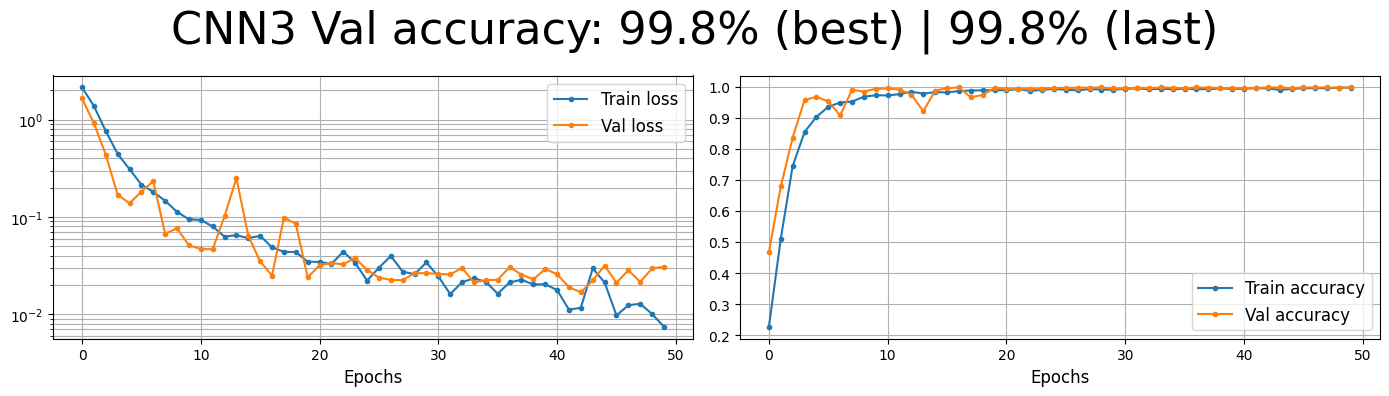

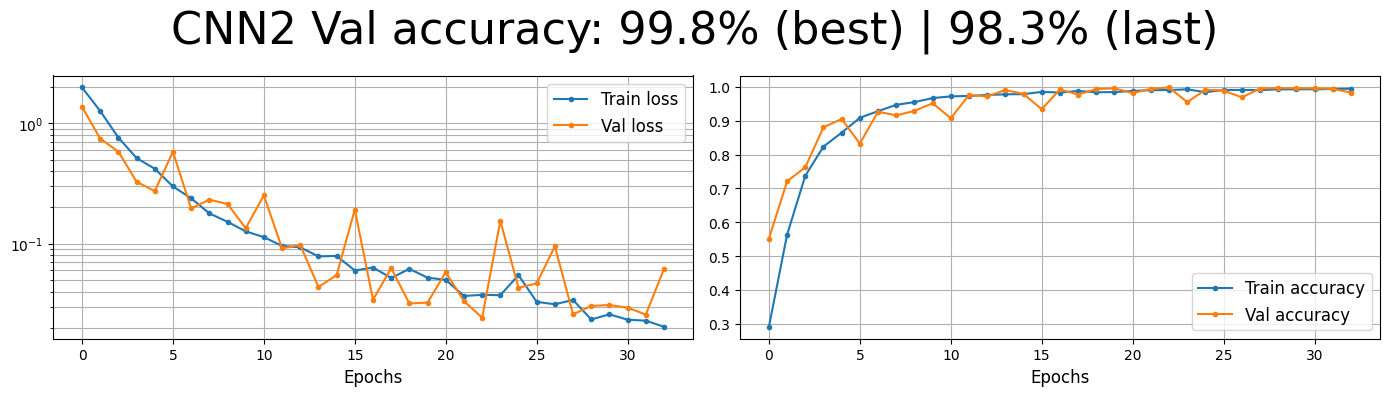

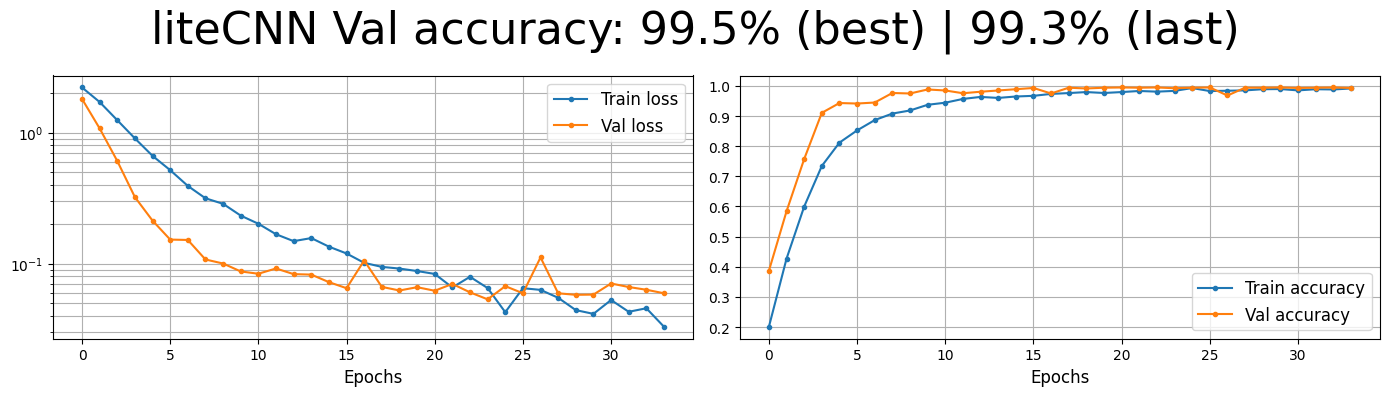

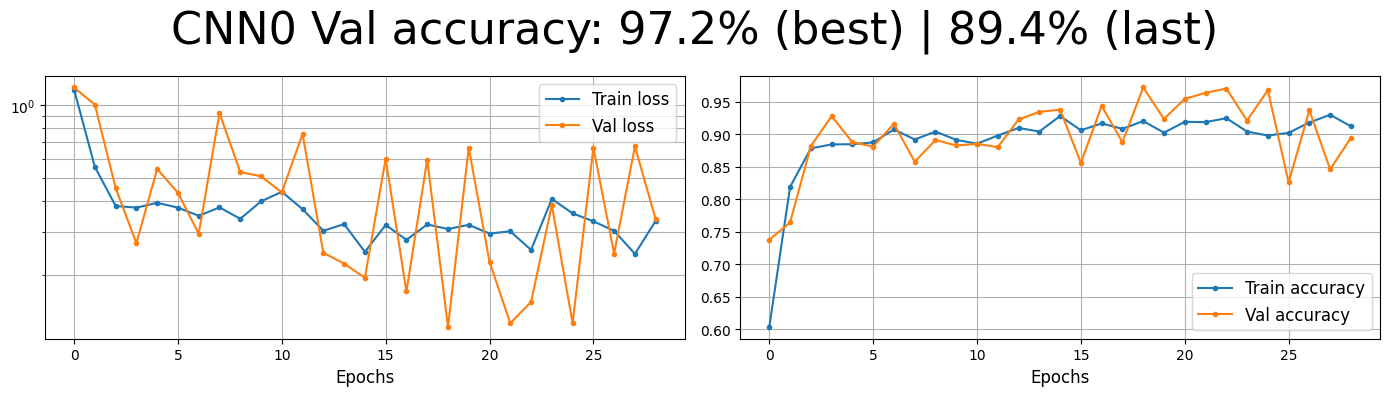

In [ ]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    ]


for i, model in enumerate(models):
  history = train(model, epochs=50, batch_size=best_hp[names[i]]['batch'], lr=best_hp[names[i]]['lr'], callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])
  full_models[names[i]] = model #armazenar modelos treinados

Acurácia do modelo CNN3 no conjunto de teste: 0.9958
75/75 [==============================] - 0s 4ms/step


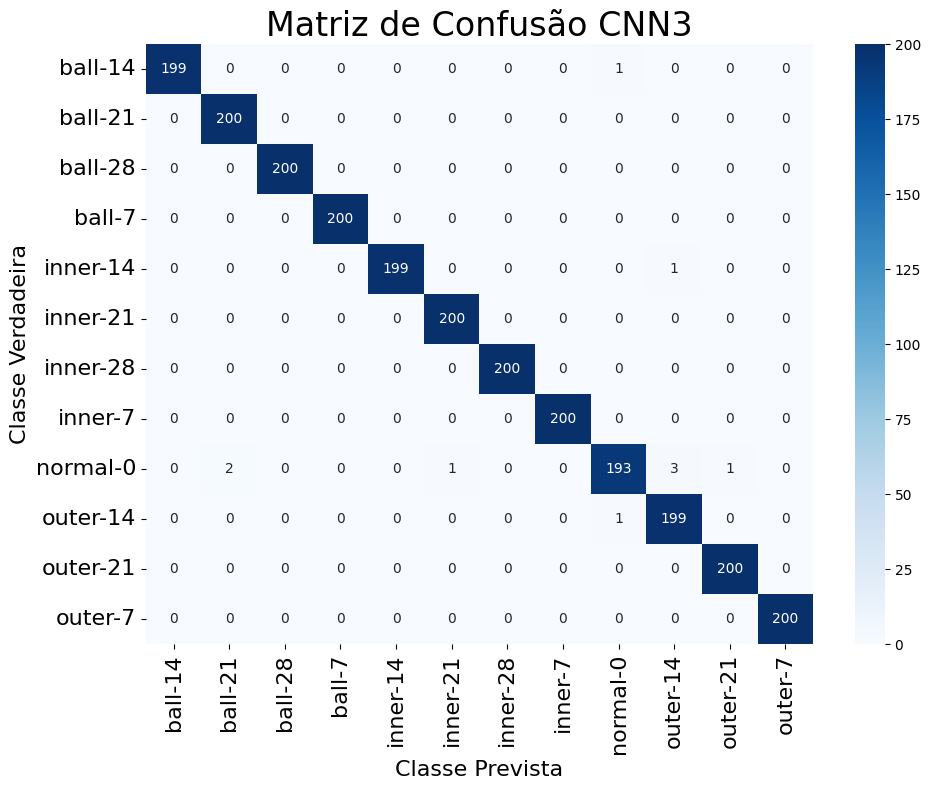

Acurácia do modelo CNN2 no conjunto de teste: 0.9812
75/75 [==============================] - 0s 3ms/step


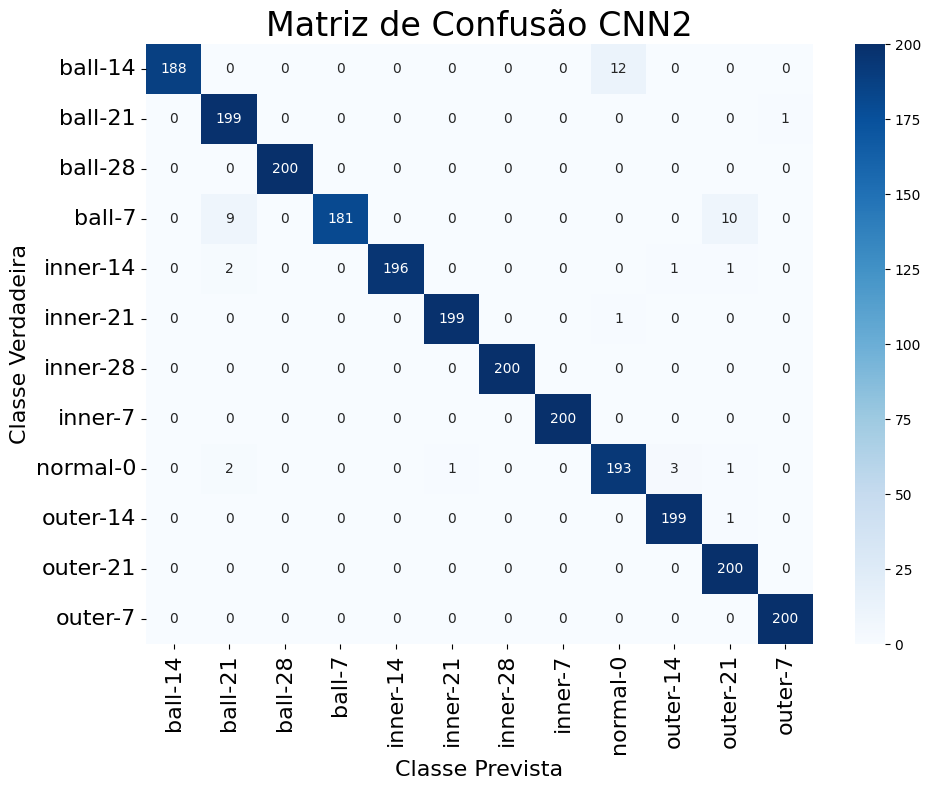

Acurácia do modelo liteCNN no conjunto de teste: 0.9917
75/75 [==============================] - 0s 2ms/step


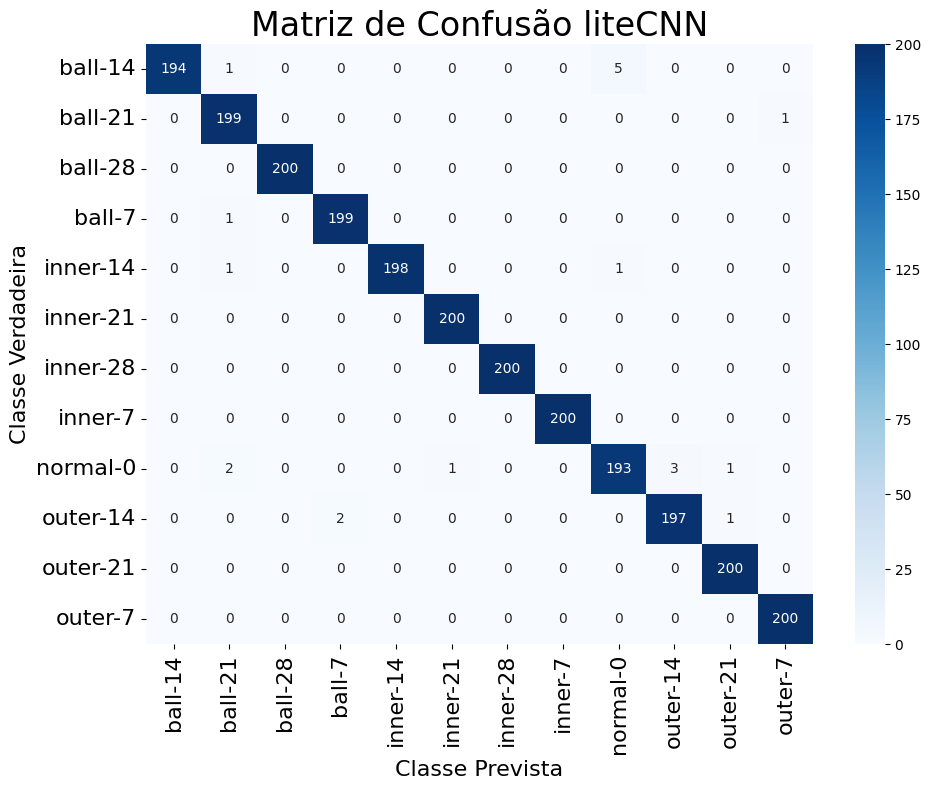

Acurácia do modelo CNN0 no conjunto de teste: 0.9121
75/75 [==============================] - 0s 838us/step


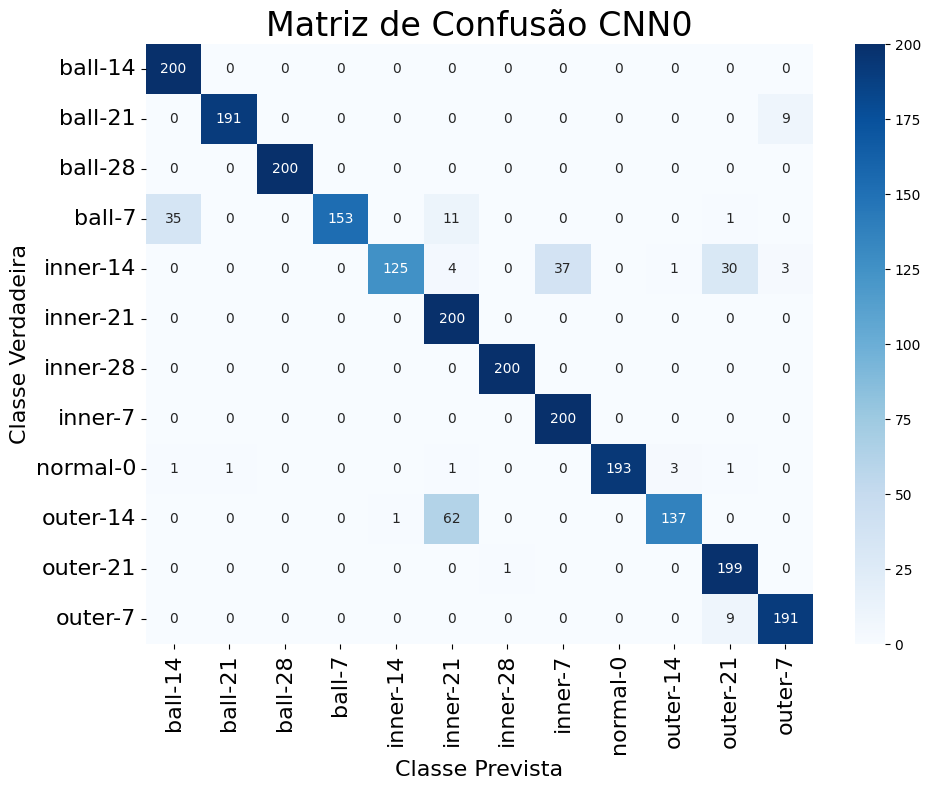

In [ ]:
for i, name in enumerate(names):
    model = full_models[name]
    # Avaliação do modelo no conjunto de teste
    accuracy = model.evaluate(X_test,y_test, verbose=0)[1]
    print(f'Acurácia do modelo {name} no conjunto de teste: {accuracy:.4f}')

    #Calculo das classes previsatas
    y_pred = model.predict(X_test)
    predicted_classes = y_pred.argmax(axis=1)

    #Transformação one hot -- inteiro
    true_classes = np.argmax(y_test,axis=1)

    # Calculando a matriz de confusão
    confusion = confusion_matrix(true_classes , predicted_classes)
    #Matriz de confusão
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('Classe Prevista',fontsize = 16)
    plt.ylabel('Classe Verdadeira',fontsize = 16)
    plt.title(f'Matriz de Confusão {name}', fontsize = 24)
    plt.tight_layout()
    plt.show()